steps:
- recalssify rasters into groups based on bins or stats
- convert the reclassified rasters to vectors
- reclassification using vectors
- use Kmeans as first pass with minimum area for a class (to avoid tiny blobs)
- use sklearn image classifiers to shorthand the work


Note on stratification - this POC does not include the step fo first excluding areas with 20% or greater tree cover (which cannot be included for carbon projects). This POC just builds out the basic backbone of notebooks that allow us to input several rasters and person some terrain analysis, geometric operations and data reclassification to get a series of polygons representing 'similar areas' within the procided area of interest. 

Important information about managing loss of spatial metadata when doing xarray operations:

https://corteva.github.io/rioxarray/html/getting_started/manage_information_loss.html

In [121]:
%pip install scikit-learn -q
%pip install scikit-image -q
%pip install spectral -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [122]:
import os
import numpy as np
import geopandas as gpd
import rasterio
import rioxarray

import xarray as xr

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import grid_to_graph

from skimage.morphology import opening, square
from skimage.filters import median

import matplotlib.pyplot as plt

import holoviews as hv
import hvplot.xarray

In [123]:
input_dir = "/workspace/notebooks/sandbox/data/stratification/processed-rasters"
output_dir = "/workspace/notebooks/sandbox/data/stratification/stratification_results"


In [124]:
input_rasters = []

for file in os.listdir(input_dir):
    if file.endswith(".tiff"):
        input_rasters.append(rioxarray.open_rasterio(os.path.join(input_dir, file)))

data_stack = xr.concat(input_rasters, dim="band")

In [155]:
# get spatial information from one of the raster to use for creating the classified raster

for file in os.listdir(input_dir):
    if file.endswith(".tiff"):
        with rasterio.open(os.path.join(input_dir, file)) as src:
            profile = src.profile
            transform = src.transform
            crs = src.crs

print(profile)
print(crs)
print(transform)


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 625, 'height': 492, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(22.96075863629066, 0.0, 12941938.268241398,
       0.0, -22.96075863629018, -3403623.0861053267), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
EPSG:3857
| 22.96, 0.00, 12941938.27|
| 0.00,-22.96,-3403623.09|
| 0.00, 0.00, 1.00|


In [125]:
# # Assuming 'data_stack' is your xarray DataArray
data_stack = data_stack.dropna(dim='y', how='any')
data_stack = data_stack.dropna(dim='x', how='any')

In [126]:
data_stack_nan = data_stack.isnull().any()
print(f"Are there NaNs in the data stack? {data_stack_nan.values}")

Are there NaNs in the data stack? False


In [127]:
# Assuming 'data_stack' is your xarray DataArray with dimensions (band, x, y)
data_stack_transposed = data_stack.transpose('y', 'x', 'band')

print(data_stack_transposed.shape)

(492, 625, 3)


In [128]:
num_features = len(data_stack_transposed.band)  # Number of bands/features
X = data_stack_transposed.values.reshape(-1, num_features)  # Flatten spatial dimensions

print("Shape of features array:", X.shape)

Shape of features array: (307500, 3)


K-means clustering is sensitive to the scale of the data. If the features (e.g., DEM values versus carbon or clay percentages) are on very different scales, the clustering might be skewed towards the feature with larger values. It’s often a good practice to scale the data.

In [129]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [130]:
# Define number of clusters
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')


kmeans.fit(scaled_features) #train it

x_cluster = kmeans.labels_ #get the labels of the classes
x_cluster_reshaped = x_cluster.reshape(data_stack_transposed[:,:,0].shape) #reshape to a 3D array with one band


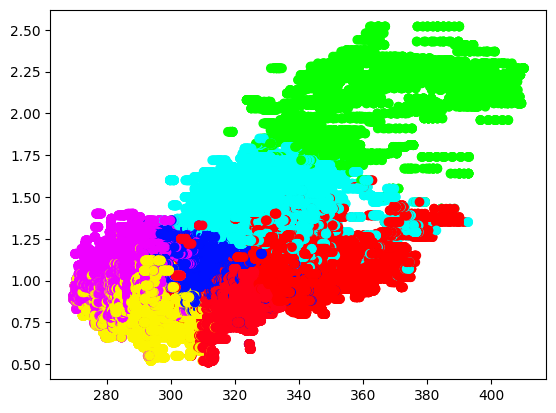

In [131]:
plt.scatter(X[:, 0], X[:, 1], c=x_cluster, cmap='hsv')  

In [132]:

print(data_stack.shape)
print(len(x_cluster_reshaped))
print(x_cluster_reshaped.shape)

(3, 492, 625)
492
(492, 625)


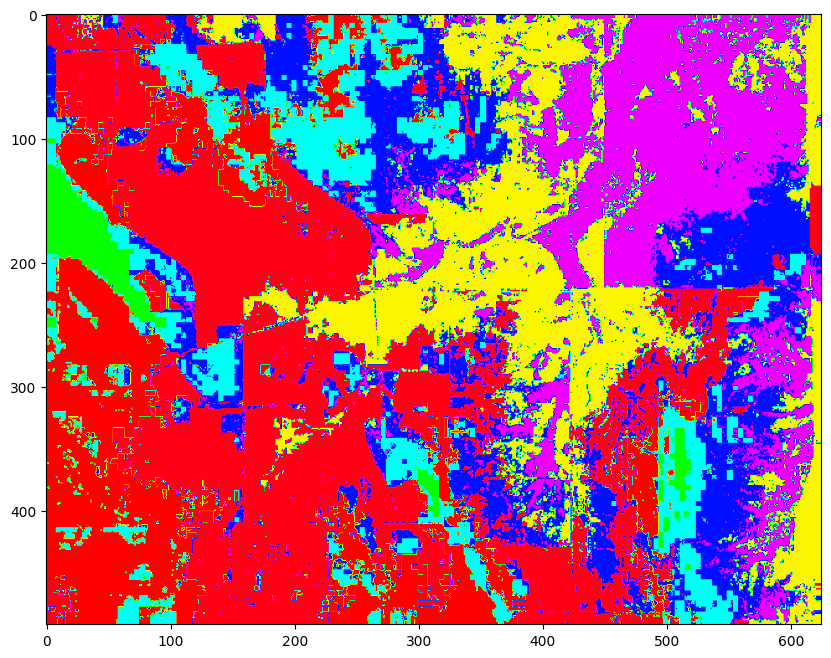

In [133]:
plt.figure(figsize=(10, 10))
plt.imshow(x_cluster_reshaped, cmap='hsv')

In [134]:
print("Shape of original data stack:", data_stack_transposed.shape)
print("Total number of elements in x_cluster:", len(x_cluster))


Shape of original data stack: (492, 625, 3)
Total number of elements in x_cluster: 307500


In [158]:
labels_da = xr.DataArray(
    x_cluster_reshaped, 
    coords={
        'y': data_stack.coords['y'],
        'x': data_stack.coords['x']
    },
    dims=['y', 'x']
)
labels_da = labels_da.rio.write_crs(crs, inplace=True)
labels_da = labels_da.rio.write_transform(transform, inplace=True)



labels_da

<xarray.DataArray (y: 492, x: 625)> Size: 1MB
array([[6, 6, 6, ..., 1, 1, 1],
       [6, 6, 6, ..., 1, 1, 1],
       [6, 6, 6, ..., 1, 1, 1],
       ...,
       [6, 6, 6, ..., 1, 1, 1],
       [6, 6, 6, ..., 1, 1, 1],
       [6, 6, 6, ..., 1, 1, 1]], dtype=int32)
Coordinates:
  * y            (y) float64 4kB -3.404e+06 -3.404e+06 ... -3.415e+06 -3.415e+06
  * x            (x) float64 5kB 1.294e+07 1.294e+07 ... 1.296e+07 1.296e+07
    spatial_ref  int64 8B 0

In [136]:
print(labels_da.shape)
print(data_stack_transposed[:, :, 0].shape)  # Adjust depending on your dimension order


(492, 625)
(492, 625)


In [138]:
labels_da.rio.to_raster(os.path.join(output_dir, "kmeans_draft.tiff"))